In [374]:
## Packages
import numpy as np
import pandas as pd
import math
# stats
from scipy import stats
import statsmodels.api as sm
from statsmodels.formula.api import ols
# machine learning
import sklearn
from sklearn import datasets
from sklearn.linear_model import LinearRegression, LogisticRegression, Ridge, Lasso, ElasticNet
from sklearn.model_selection import KFold, cross_val_score, StratifiedKFold, train_test_split
# ploting
import matplotlib.pyplot as plt
import seaborn as sns

ImportError: cannot import name 'smfa' from 'statsmodels.formula.api' (/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/statsmodels/formula/api.py)

In [ ]:
## Settings
%matplotlib inline
#pd.describe_option('display')
pd.set_option('display.max_columns', None)  
pd.set_option('display.min_rows', 1) # so show all rows
pd.set_option('display.max_rows', None)  
#pd.set_option('display.max_colwidth', None)
#pd.set_option('max_colwidth', None)
#pd.option_context()

In [ ]:
!pwd

## Data Input

In [350]:
## read in csv
trainf = pd.read_csv('../processed_data/train_full.csv')
traino = pd.read_csv('../processed_data/train_ordinal.csv')
traind = pd.read_csv('../processed_data/train_dummy.csv')
traindo = pd.read_csv('../processed_data/train_dummy_ordinal.csv')

In [351]:
# get rid of extra id column
trainf.drop(['Unnamed: 0'],axis=1, inplace=True)
traind.drop(['Unnamed: 0'],axis=1, inplace=True)
traindo.drop(['Unnamed: 0'],axis=1, inplace=True)

In [352]:
## set Id as index
trainf = trainf.set_index('Id')
traino = traino.set_index('Id')
traind = traind.set_index('Id')
traindo = traindo.set_index('Id')

In [353]:
print(trainf.shape)
print(traino.shape)
print(traind.shape)
print(traindo.shape)

(1460, 80)
(1460, 83)
(1460, 286)
(1460, 225)


In [365]:
df = traindo.copy()

## EDA: plots

In [ ]:
print(df.shape)
df.head(20)
display(df.columns)
traind.columns.to_list()

In [ ]:
## Histogram of Sale Price -- use log SalePrice in EDA and model fitting
plt.hist(df.SalePrice, bins = 30)
plt.show()
plt.hist(df.SalePrice, bins = 30)
plt.xscale("log")
plt.show()
#plt.xscale("log")
#mu, sigma = stats.norm.fit(df.SalePrice)
#best_fit_line = stats.norm.pdf(20, mu, sigma)
#plt.plot(20, best_fit_line)

In [ ]:
## Boxplot of Sale Price vs categorical variables
# individual boxplots
# sns.boxplot(x='LotShape', y='SalePrice', data=df)
# plt.show()
# boxplot_saleprice(df_saleprice_c, 'LandSlope')
# plt.show()

# group boxplots
df_saleprice_c = df[df.SalePrice.apply(lambda x: np.abs(x-df.SalePrice.mean())/df.SalePrice.std() < 2)] # 95% of data
#print(sns.boxplot(x='LotShape', y='SalePrice', data=df_saleprice_c))
def boxplot_saleprice(df, col):
    sns.boxplot(x=col, y='SalePrice', data=df)
    plt.show()

#boxplot_saleprice(df_saleprice_c, 'LandSlope')
list(map(lambda x: boxplot_saleprice(df_saleprice_c, x), cate_features))

In [ ]:
sns.boxplot(x = 'OverallQual', y = 'SalePrice', data = df)

In [ ]:
# t test
stats.ttest_ind(df.loc[df.LotShape == 'reg', "SalePrice"], df.loc[df.LotShape == 'ir1', "SalePrice"])

In [ ]:
## Sale Price vs Year Built: should year built be ordinal? -- no, should categorize to decades and be nominal
plt.hist(df.YearBuilt, bins = 40)

## EDA: correlation & anova

### 1.  data transformation & predictor types

In [379]:
## add log SalePrice
df["logSalePrice"] = df.SalePrice.map(lambda x: math.log(x))
df.head()

,LotFrontage,LotArea,LandSlope,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,ExterQual,ExterCond,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,HeatingQC,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,MiscVal,MoSold,YrSold,SalePrice,decade_YearBuilt,decade_YearRemodAdd,decade_GarageYrBlt,MSSubClass_30,MSSubClass_40,MSSubClass_45,MSSubClass_50,MSSubClass_60,MSSubClass_70,MSSubClass_75,MSSubClass_80,MSSubClass_85,MSSubClass_90,MSSubClass_120,MSSubClass_160,MSSubClass_180,MSSubClass_190,MSZoning_fv,MSZoning_rh,MSZoning_rl,MSZoning_rm,Street_pave,Alley_nothing,Alley_pave,LotShape_ir2,LotShape_ir3,LotShape_reg,LandContour_hls,LandContour_low,LandContour_lvl,Utilities_nosewa,LotConfig_culdsac,LotConfig_fr2,LotConfig_fr3,LotConfig_inside,Neighborhood_blueste,Neighborhood_brdale,Neighborhood_brkside,Neighborhood_clearcr,Neighborhood_collgcr,Neighborhood_crawfor,Neighborhood_edwards,Neighborhood_gilbert,Neighborhood_idotrr,Neighborhood_meadowv,Neighborhood_mitchel,Neighborhood_names,Neighborhood_noridge,Neighborhood_npkvill,Neighborhood_nridght,Neighborhood_nwames,Neighborhood_oldtown,Neighborhood_sawyer,Neighborhood_sawyerw,Neighborhood_somerst,Neighborhood_stonebr,Neighborhood_swisu,Neighborhood_timber,Neighborhood_veenker,Condition1_feedr,Condition1_norm,Condition1_posa,Condition1_posn,Condition1_rrae,Condition1_rran,Condition1_rrne,Condition1_rrnn,Condition2_feedr,Condition2_norm,Condition2_posa,Condition2_posn,Condition2_rrae,Condition2_rran,Condition2_rrnn,BldgType_2fmcon,BldgType_duplex,BldgType_twnhs,BldgType_twnhse,HouseStyle_1.5unf,HouseStyle_1story,HouseStyle_2.5fin,HouseStyle_2.5unf,HouseStyle_2story,HouseStyle_sfoyer,HouseStyle_slvl,RoofStyle_gable,RoofStyle_gambrel,RoofStyle_hip,RoofStyle_mansard,RoofStyle_shed,RoofMatl_compshg,RoofMatl_membran,RoofMatl_metal,RoofMatl_roll,RoofMatl_tar&grv,RoofMatl_wdshake,RoofMatl_wdshngl,Exterior1st_asphshn,Exterior1st_brkcomm,Exterior1st_brkface,Exterior1st_cblock,Exterior1st_cemntbd,Exterior1st_hdboard,Exterior1st_imstucc,Exterior1st_metalsd,Exterior1st_plywood,Exterior1st_stone,Exterior1st_stucco,Exterior1st_vinylsd,Exterior1st_wd sdng,Exterior1st_wdshing,Exterior2nd_asphshn,Exterior2nd_brk cmn,Exterior2nd_brkface,Exterior2nd_cblock,Exterior2nd_cmentbd,Exterior2nd_hdboard,Exterior2nd_imstucc,Exterior2nd_metalsd,Exterior2nd_other,Exterior2nd_plywood,Exterior2nd_stone,Exterior2nd_stucco,Exterior2nd_vinylsd,Exterior2nd_wd sdng,Exterior2nd_wd shng,MasVnrType_brkface,MasVnrType_nothing,MasVnrType_stone,Foundation_cblock,Foundation_pconc,Foundation_slab,Foundation_stone,Foundation_wood,Heating_gasa,Heating_gasw,Heating_grav,Heating_othw,Heating_wall,CentralAir_y,Electrical_fusef,Electrical_fusep,Electrical_mix,Electrical_sbrkr,GarageType_attchd,GarageType_basment,GarageType_builtin,GarageType_carport,GarageType_detchd,GarageType_nothing,PavedDrive_p,PavedDrive_y,Fence_gdwo,Fence_mnprv,Fence_mnww,Fence_nothing,MiscFeature_nothing,MiscFeature_othr,MiscFeature_shed,MiscFeature_tenc,SaleType_con,SaleType_conld,SaleType_conli,SaleType_conlw,SaleType_cwd,SaleType_new,SaleType_oth,SaleType_wd,SaleCondition_adjland,SaleCondition_alloca,SaleCondition_family,SaleCondition_normal,SaleCondition_partial,logSalePrice
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,65,8450,3,7,5,2003,2003,196,4,3,4,3,1,6,706,1,0,150,856,5,856,854,0,1710,1,0,2,1,3,1,4,8,8,0,0,2003,2,2,548,3,3,0,61,0,0,0,0,0,0,2,2008,208500,10,10,10,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1,1,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0

In [366]:
print('total columns - include Id:', len(df.columns.to_list()))
df.shape
df.columns.to_list()

total columns - include Id: 225


['LotFrontage',
 'LotArea',
 'LandSlope',
 'OverallQual',
 'OverallCond',
 'YearBuilt',
 'YearRemodAdd',
 'MasVnrArea',
 'ExterQual',
 'ExterCond',
 'BsmtQual',
 'BsmtCond',
 'BsmtExposure',
 'BsmtFinType1',
 'BsmtFinSF1',
 'BsmtFinType2',
 'BsmtFinSF2',
 'BsmtUnfSF',
 'TotalBsmtSF',
 'HeatingQC',
 '1stFlrSF',
 '2ndFlrSF',
 'LowQualFinSF',
 'GrLivArea',
 'BsmtFullBath',
 'BsmtHalfBath',
 'FullBath',
 'HalfBath',
 'BedroomAbvGr',
 'KitchenAbvGr',
 'KitchenQual',
 'TotRmsAbvGrd',
 'Functional',
 'Fireplaces',
 'FireplaceQu',
 'GarageYrBlt',
 'GarageFinish',
 'GarageCars',
 'GarageArea',
 'GarageQual',
 'GarageCond',
 'WoodDeckSF',
 'OpenPorchSF',
 'EnclosedPorch',
 '3SsnPorch',
 'ScreenPorch',
 'PoolArea',
 'PoolQC',
 'MiscVal',
 'MoSold',
 'YrSold',
 'SalePrice',
 'decade_YearBuilt',
 'decade_YearRemodAdd',
 'decade_GarageYrBlt',
 'MSSubClass_30',
 'MSSubClass_40',
 'MSSubClass_45',
 'MSSubClass_50',
 'MSSubClass_60',
 'MSSubClass_70',
 'MSSubClass_75',
 'MSSubClass_80',
 'MSSubClass_85

In [367]:
## Categorical variable columns
cate_features = df[df.applymap(np.isreal) == False].dropna(axis = 1).columns.tolist()
#cate_features.extend(["MSSubClass", "OverallQual", "OverallCond"])
len(cate_features)

0

In [368]:
## Numerical variable columns
num_features = df[df.applymap(np.isreal)==True].dropna(axis=1).columns.tolist()
# num_features.remove("MSSubClass")
# num_features.remove("OverallQual")
# num_features.remove("OverallCond")
len(num_features)

225

### 2. correlation matrix

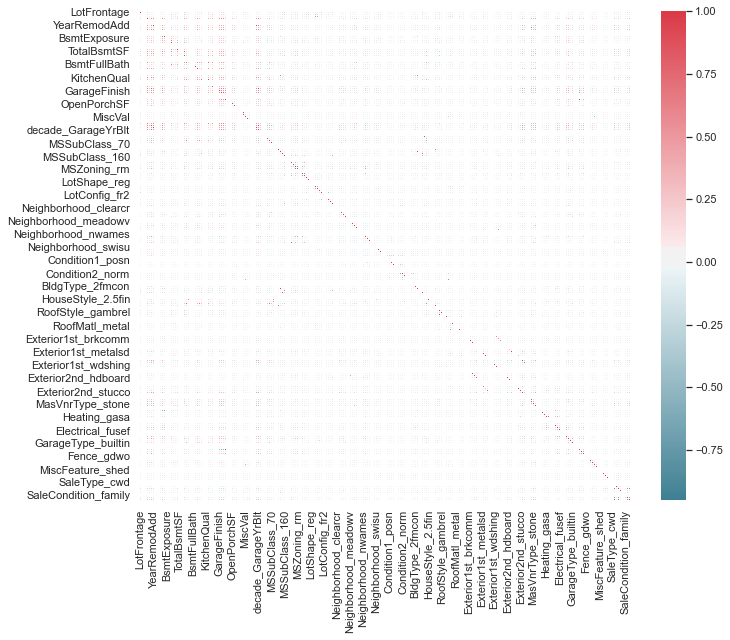

In [369]:
# correlation matrix plot
sns.set(style="white")
corr = df.corr()
f, ax = plt.subplots(figsize = (11,9))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(corr, cmap = cmap, linewidths=0.5)
#sns.heatmap(corr, cmap = cmap, center = 0, square = True, linewidths=0.5, cbar_kws={"shrink": 0.5})

In [370]:
"LotFrontage" in df.columns.to_list()

True

In [372]:
## correlation matrix of numerical predictors

corr_matrix = pd.DataFrame(columns=['feature','corr'])

for x in num_features :
    value, _ = stats.pearsonr(df[x], df['SalePrice'])
    corr_matrix = corr_matrix.append({'feature':x, 'corr':value}, ignore_index=True)

print('Correlation by Feature:')
display(corr_matrix.sort_values(by=['corr'], ascending=False))

Correlation by Feature:


,feature,corr
51,SalePrice,1.000000
3,OverallQual,0.790982
23,GrLivArea,0.708624
8,ExterQual,0.682639
30,KitchenQual,0.659600
37,GarageCars,0.640409
38,GarageArea,0.623431
18,TotalBsmtSF,0.613581
20,1stFlrSF,0.605852
10,BsmtQual,0.585207


In [ ]:
## anova of categorical predictors (all combination t-test later?)
model = ols('SalePrice ~C(LandSlope)', data = df).fit()
anova_table = sm.stats.anova_lm(model, typ = 2)
#display(anova_table)

test_col = 'LandSlope'
compare = "SalePrice ~C(" + test_col + ")"
model = ols(compare, data = df).fit()
anova_table = sm.stats.anova_lm(model, typ = 2)
#display(anova_table)
#type(anova_table)

def anova_test(df, test_col):
    compare = "logSalePrice ~C(" + test_col + ")"
    model = ols(compare, data = df).fit()
    anova_table = sm.stats.anova_lm(model, typ = 2)
    return anova_table
#display(anova_test(df, "LandSlope"))

anova_list = list(map(lambda x: anova_test(df, x), cate_features))
for item in anova_list:
    display(item)


## Model Fitting

In [386]:
X, y = np.arange(10).reshape((5, 2)), range(5)
display(X)
list(y)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=42)
display(X_train, y_train)

array([[0, 1],
       [2, 3],
       [4, 5],
       [6, 7],
       [8, 9]])

array([[4, 5],
       [0, 1],
       [6, 7]])

[2, 0, 3]

### 0. clean data set

In [397]:
# remove outlier Id524, Id1299
drop_rows = df[df.index.isin([524, 1299])].index
df.drop(drop_rows, inplace=True)
print("df shape after drop outlier rows:", df.shape)

df shape after drop outlier rows: (1458, 226)


In [ ]:
# drop columns: Utilities, Alley, PoolQC, YearRemodAdd, GarageYrBlt -- ignore if using data set with dummy variables
drop_cols = ["Utilities", "Alley", "PoolQC", "YearRemodAdd", "GarageYrBlt"]
df.drop(drop_cols, axis = 1, inplace=True)
print("df shape after drop selected columns:", df.shape)

### 1. Lasso Regression

In [412]:
## split to train & validation
xtrain, xtest, ytrain, ytest = train_test_split(df.drop(['SalePrice', 'logSalePrice'], axis = 1), df.logSalePrice, test_size = 0.2, random_state = 4)

In [434]:
## cross validation
ms_k5s = StratifiedKFold(n_splits=5)
for train_idx, val_idx in ms_k5s.split(X = xtrain, y = logSalePrice):
    print('Train:', train_idx, 'Validation:', val_idx)

#ms_k5s.split(X = df.drop(['SalePrice', 'logSalePrice'], axis = 1), y = df.logSalePrice)

NameError: name 'logSalePrice' is not defined

In [436]:
## set up Lasso regression model
lasso = Lasso(normalize=True, alpha = 1e-3)
#alphas = np.linspace(1e-10, 1, 10)
alphas


array([1.00000000e-10, 1.11111111e-01, 2.22222222e-01, 3.33333333e-01,
       4.44444444e-01, 5.55555556e-01, 6.66666667e-01, 7.77777778e-01,
       8.88888889e-01, 1.00000000e+00])

In [430]:
lasso.fit(xtrain, ytrain)

Lasso(alpha=0.01, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=True, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)

In [431]:
lasso.coef_

array([ 0.,  0., -0.,  0., -0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., -0.,  0.,  0., -0.,
        0.,  0.,  0., -0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0., -0.,  0.,  0.,  0.,  0., -0.,  0., -0.,  0.,
        0.,  0., -0., -0., -0., -0.,  0., -0.,  0., -0., -0., -0.,  0.,
       -0., -0., -0.,  0., -0.,  0., -0.,  0.,  0., -0.,  0.,  0., -0.,
        0.,  0., -0., -0.,  0.,  0.,  0., -0., -0., -0., -0.,  0.,  0.,
        0., -0.,  0., -0., -0., -0., -0.,  0., -0.,  0.,  0., -0., -0.,
        0.,  0.,  0., -0.,  0.,  0., -0.,  0.,  0.,  0., -0.,  0.,  0.,
       -0., -0.,  0.,  0.,  0.,  0., -0.,  0., -0., -0., -0.,  0., -0.,
       -0.,  0., -0.,  0., -0., -0., -0., -0.,  0.,  0.,  0., -0.,  0.,
        0.,  0.,  0.,  0.,  0., -0., -0.,  0., -0.,  0., -0.,  0., -0.,
        0.,  0., -0.,  0., -0., -0., -0., -0.,  0., -0.,  0., -0., -0.,
       -0.,  0., -0., -0., -0.,  0., -0., -0.,  0., -0.,  0., -0

In [ ]:
lasso  = Lasso()
alphas = np.linspace(0.1,20,10)
lasso.set_params(normalize=False)
coefs_lasso  = []

for alpha in alphas:
        lasso.set_params(alpha=alpha)
        lasso.fit(traino, SalePrice)  
        coefs_lasso.append(lasso.coef_)

coefs_lasso = pd.DataFrame(coefs_lasso, index = alphas, columns = traino.columns)  
coefs_lasso.head()